# Does amplicon bias help?
> Let's see if we should even keep this term

Using the experimental amplicon bias term introduced on Nov 29 2022

In [7]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from src.simulation_new import make_tables
from src.database import RnaDB
from src.torch_solver import TorchSolver

In [9]:
rnadb = RnaDB(
    path_to_dnaA = "../../data/allDnaA.tsv",
    path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [10]:
# Copied from scaling_experiment_matrix.ipynb

def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


In [11]:
# Experiment 1: how much worse is the solution when we have a free bias term?

results = pd.DataFrame()
for multiplier in range(-3, 3):
    scale = 10 ** multiplier
    print(f"Scale: {scale}")
    abundances, log2_ptrs, otus = make_tables(
        db=rnadb,
        n_samples=20,
        n_genomes=10,
        sparsity=0,
        multiplier=scale
    )
    for bias in [True, False]:
        solver = TorchSolver(otus=otus, db=rnadb)
        solver.train(lr=0.1, clip=True, model_bias=bias)
        ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
            solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append({
                        "scale": scale,
                        "bias": bias,
                        "genome": genome_id,
                        "sample": sample_id,
                        "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                        "ptr_score": ptr_score.loc[genome_id, sample_id],
                        "abundance_true": abundances.loc[genome_id, sample_id],
                        "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                        "abundance_score": abundance_score.loc[genome_id, sample_id],
                    }, ignore_index=True)
                except KeyError:
                    print(f"==============KeyError: {genome_id}, {sample_id}")


Scale: 0.001
Using OTU index for md5s
Initial:	 1.038498044013977
Epoch 0:	 0.11177501827478409
Epoch 1:	 0.11129991710186005
Epoch 2:	 0.111107237637043
Epoch 3:	 0.11091640591621399
Epoch 4:	 0.11083893477916718
Epoch 5:	 0.11083899438381195
Epoch 6:	 0.11095155775547028
Epoch 7:	 0.11085770279169083
Epoch 8:	 0.11083615571260452
Epoch 9:	 0.11083167791366577
Epoch 10:	 0.11101064085960388
Epoch 11:	 0.11087088286876678
Epoch 12:	 0.11092525720596313
Epoch 13:	 0.1109192818403244
Epoch 14:	 0.11083497852087021
Epoch 15:	 0.11167751252651215
Using OTU index for md5s
Initial:	 1.038498044013977
Epoch 0:	 0.12327355146408081
Epoch 1:	 0.12327354401350021
Epoch 2:	 0.12327411770820618
Epoch 3:	 0.12328806519508362
Epoch 4:	 0.12331005185842514
Epoch 5:	 0.1232849657535553
Epoch 6:	 0.12330637127161026
Epoch 7:	 0.12328930199146271
Scale: 0.01
Using OTU index for md5s
Initial:	 -8.516465187072754
Epoch 0:	 -22.56084442138672
Epoch 1:	 -22.59548568725586
Epoch 2:	 -22.60236167907715
Epoch 

Text(0.5, 1.0, 'Biased vs. unbiased PTR error vs. scale, unbiased reads case')

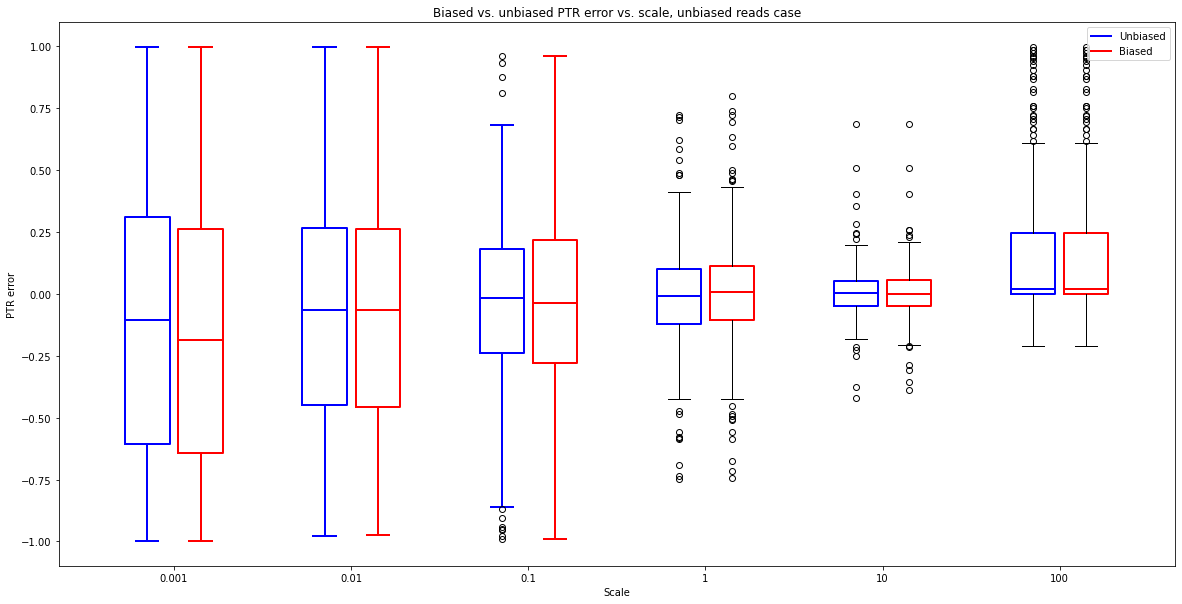

In [12]:
fig = plt.figure(figsize=(20, 10))

# Make data
for_boxplot_unbiased = results[results["bias"] == False]
for_boxplot_bias = results[results["bias"] == True]
x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["blue", "red"]):
    for median, box, cap, line in zip(
        b["medians"], b["boxes"], b["caps"], b["whiskers"]
    ):
        median.set(color=c, linewidth=2)
        box.set(color=c, linewidth=2)
        cap.set(color=c, linewidth=2)
        line.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"])
plt.title("Biased vs. unbiased PTR error vs. scale, unbiased reads case")


In [33]:
# Experiment 2: how much worse is the solution when we have a free bias term AND bias?

results = pd.DataFrame()
for multiplier in range(-3, 3):
    scale = 10 ** multiplier
    print(f"Scale: {scale}")
    abundances, log2_ptrs, otus = make_tables(
        db=rnadb,
        n_samples=20,
        n_genomes=10,
        sparsity=0,
        multiplier=scale
    )
    # Add per-md5 bias term
    otus = otus.multiply(np.random.rand(otus.shape[0]), axis=0) 
    for bias in [True, False]:
        solver = TorchSolver(otus=otus, db=rnadb)
        solver.train(lr=0.1, clip=True, model_bias=bias)
        ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
            solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append({
                        "scale": scale,
                        "bias": bias,
                        "genome": genome_id,
                        "sample": sample_id,
                        "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                        "ptr_score": ptr_score.loc[genome_id, sample_id],
                        "abundance_true": abundances.loc[genome_id, sample_id],
                        "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                        "abundance_score": abundance_score.loc[genome_id, sample_id],
                    }, ignore_index=True)
                except KeyError:
                    print(f"==============KeyError: {genome_id}, {sample_id}")


Scale: 0.001
Using OTU index for md5s
Initial:	 1.6471896171569824
Epoch 0:	 0.47491127252578735
Epoch 1:	 0.47256216406822205
Epoch 2:	 0.46833446621894836
Epoch 3:	 0.46427106857299805
Epoch 4:	 0.4594999849796295
Epoch 5:	 0.45304158329963684
Epoch 6:	 0.5217152833938599
Epoch 7:	 0.5147956013679504
Epoch 8:	 0.5077981948852539
Epoch 9:	 0.5019249320030212
Epoch 10:	 0.5010429620742798
Epoch 11:	 0.4995878338813782
Using OTU index for md5s
Initial:	 1.6471896171569824
Epoch 0:	 0.5808084011077881
Epoch 1:	 0.615364670753479
Epoch 2:	 0.6146669983863831
Epoch 3:	 0.7329988479614258
Epoch 4:	 0.764892578125
Epoch 5:	 0.8913069367408752
Epoch 6:	 0.8861039280891418
Scale: 0.01
Using OTU index for md5s
Initial:	 -2.462153434753418
Epoch 0:	 -7.421348571777344
Epoch 1:	 -7.428192615509033
Epoch 2:	 -7.4282732009887695
Epoch 3:	 -7.428333282470703
Epoch 4:	 -7.4283366203308105
Epoch 5:	 -7.4283905029296875
Epoch 6:	 -7.4283599853515625
Epoch 7:	 -7.428181171417236
Epoch 8:	 -7.42837095260

Text(0.5, 1.0, 'Biased vs. unbiased PTR error vs. scale, unbiased reads case')

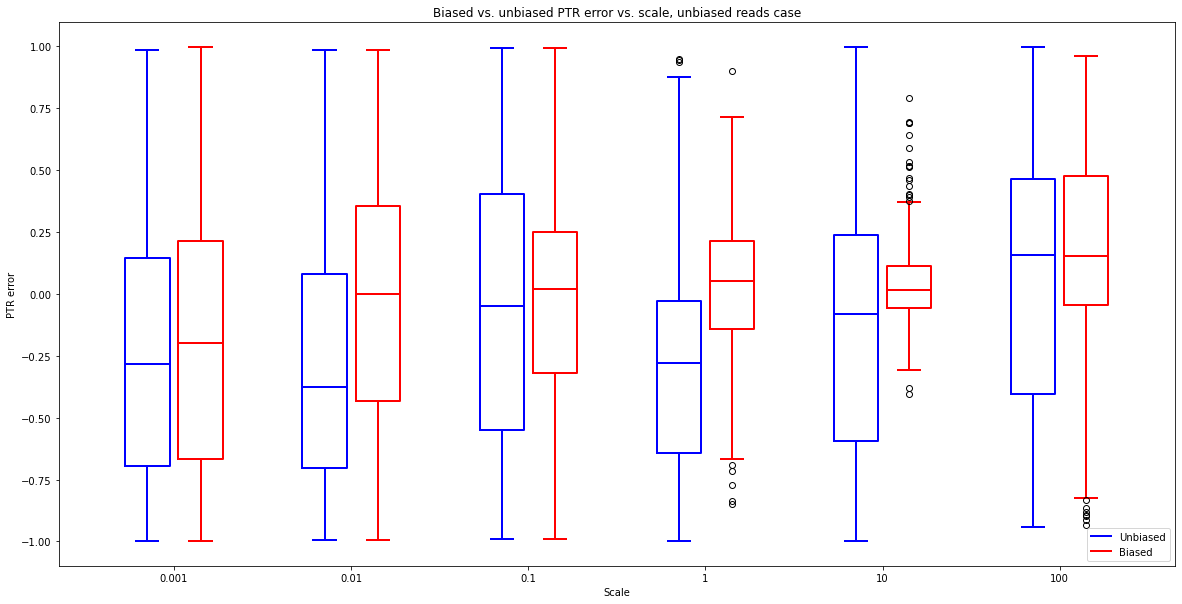

In [37]:
fig = plt.figure(figsize=(20, 10))

# Make data
for_boxplot_unbiased = results[results["bias"] == False]
for_boxplot_bias = results[results["bias"] == True]
x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")

# Change colors for medians
for b, c in zip([bp1, bp2], ["blue", "red"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"])
plt.title("Biased vs. unbiased PTR error vs. scale, unbiased reads case")


In [ ]:
solver = TorchSolver(otus=otus, db=rnadb)
solver.train(lr=0.1, clip=True, model_bias=bias)
ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
    solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
)
for i, genome_id in enumerate(solver.genome_ids):
    for j, sample_id in enumerate(solver.sample_ids):
        try:
            results = results.append({
                "scale": scale,
                "bias": bias,
                "genome": genome_id,
                "sample": sample_id,
                "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                "ptr_score": ptr_score.loc[genome_id, sample_id],
                "abundance_true": abundances.loc[genome_id, sample_id],
                "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                "abundance_score": abundance_score.loc[genome_id, sample_id],
            }, ignore_index=True)
        except KeyError:
            print(f"==============KeyError: {genome_id}, {sample_id}")
